[<img  align="right" src="https://www.gustaveroussy.fr/sites/all/themes/gustave_roussy/logo.png">](https://www.gustaveroussy.fr/)
# ScreenFail prediction 
*Modelisation with Random Forest to predict if a patient will be Screen Fail or not*

### 

In [32]:
# Import necessary librairies
import os

import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, GridSearchCV, train_test_split,RandomizedSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, average_precision_score, \
    classification_report, recall_score, f1_score, roc_auc_score, make_scorer, auc
from sklearn.covariance import EmpiricalCovariance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from gensim.models import Word2Vec, KeyedVectors 

import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, Birch, DBSCAN

from w2v_clusters import WordClustering
from pre_process import process

import shap


*Load and prepares EHRs for further processing*

In [3]:
# Load EHRs
df_all=pd.read_csv(os.path.join("./Data", "df_CRs_inclusion.csv"), encoding='utf-8')
df_all=df_all[df_all['CompleteValues']]

# Separe Test and Train/Validation sets
split = df_all['Cohort']

ehr_raw_train_val=df_all[split!="Test"].value.apply(str)
ehr_raw_test=df_all[split=="Test"].value.apply(str)

y_train_val=df_all.loc[split!="Test"].screenfail
y_test=df_all.loc[split=="Test"].screenfail
pd.value_counts(y_train_val) # give numbers of ScreenFail in test and val cohort


0    920
1    697
Name: screenfail, dtype: int64

*Processing of EHRS*

In [5]:
# Preprocessing using spacy: html,stopwords,ponctuation and lemmatisation
  
ehr_train_val=ehr_raw_train_val.apply(process)    
ehr_test=ehr_raw_test.apply(process)    

# Delete empty health records
ehr_train_val = pd.DataFrame(data=ehr_train_val)
ehr_test = pd.DataFrame(data=ehr_test)

# Found index of null DafaFrames and delete them
index_with_nan_train_val = ehr_train_val.index[ehr_train_val.isnull().any(axis=1)]
index_with_nan_test = ehr_test.index[ehr_test.isnull().any(axis=1)]

ehr_train_val=ehr_train_val.drop(index_with_nan_train_val,0, inplace=False)
ehr_test=ehr_test.drop(index_with_nan_test,0, inplace=False)

ehr_train_val=pd.Series(ehr_train_val.value) 
ehr_test=pd.Series(ehr_test.value)

y_train_val=y_train_val.drop(index_with_nan_train_val,0, inplace=False)
y_test=y_test.drop(index_with_nan_test,0, inplace=False)



*Separe Training and validation test*

In [6]:
split=split.drop(index_with_nan_train_val,0, inplace=False)
index_val=split.index[split == "Val"].to_list()
index_train=split.index[split == "Train"].to_list()
DF_val=ehr_train_val[index_val]
DF_train=ehr_train_val[index_train]

y_val=y_train_val[index_val]
y_train=y_train_val[index_train]

*Initialisation of cross validation*

In [8]:
# CV is then performed with StratifiedShuffleSplit funtion
cv = StratifiedShuffleSplit(n_splits=5, test_size=len(DF_val)/(len(DF_val)+len(DF_train)), random_state=42)
scoring = {'AUC': 'roc_auc','f1':'f1', 'Recall': 'recall'}

*Transformation into cluster vectors*

In [12]:
w2v_cluster = WordClustering( pretrained=True,
                              model_path="w2v_model.kv",
                              n_clusters=300,
                             clustering=AgglomerativeClustering())


model_vectors =w2v_cluster.fit(ehr_train_val)

ehrs_vec_train_val=model_vectors.transform(ehr_train_val)
#x_w2v2_val=x_w2v.transform(DF_val) ?
#x_w2v2_train=x_w2v.transform(DF_train) ?
ehrs_vec_test=model_vectors.transform(ehr_test)

oui


*Random Forest and search for best parameters*

In [13]:

rf = RandomForestClassifier(random_state=15)

params = {'n_estimators': np.arange(5, 200, 1),
          'max_features': ['log2', 'sqrt'],
          'min_samples_leaf': np.arange(1E-8, 0.01, 1E-8)}

grid = RandomizedSearchCV(rf,
                    param_distributions=params,
                    cv=cv,
                    scoring=scoring,
                    refit='Recall',
                    return_train_score=False,
                    verbose=1,
                    n_jobs=-1,
                    random_state=42,
                    n_iter=1200)

grid.fit(ehrs_vec_train_val, y_train_val)

y_pred_train_val = grid.predict(ehrs_vec_train_val)


Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:  9.9min finished


Results

In [28]:
best_params=grid.best_params_ # store best parameters of the random forest

y_pred_train_val = grid.predict(ehrs_vec_train_val)
y_prob_train_val = grid.predict_proba(ehrs_vec_train_val) # get probabilities of each class

y_pred_test = grid.predict(ehrs_vec_test)
y_prob_test = grid.predict_proba(ehrs_vec_test)

                                                           
### Results for test set ###

print("Results for test set ","\n\n")

mat_test=confusion_matrix(y_test, y_pred_test)
print("confusion matrix:" , mat_test,"\n")

fpr_test, tpr_test, threshold_test = roc_curve(y_test,y_prob_test[:,1])
score_auc_test = auc(fpr_test,tpr_test)
print("score auc: ",score_auc_test,"\n")

score_f1_test=f1_score(y_test, y_pred_test)
print("score f1: ",score_f1_test,"\n")

score_recall_test=recall_score(y_test, y_pred_test)
print("score recall: ",score_recall_test ,"\n")

### Results for train and validation set ###

print("Results for training and validation set ","\n\n")
                                               
mat_train_val=confusion_matrix(y_train_val, y_pred_train_val)
print("confusion matrix:",mat_train_val,"\n")
                                               
fpr_train_val, tpr_train_val, threshold_train_val = roc_curve(y_train_val,y_prob_train_val[:,1])
score_auc_train_val=auc(fpr_train_val,tpr_train_val)
print("score auc: ",score_auc_train_val,"\n")

score_f1_train_val=f1_score(y_train_val, y_pred_train_val)
print("score f1: ",score_f1_train_val,"\n")

score_recall_train_val=recall_score(y_train_val, y_pred_train_val)
print("score recall: ",score_recall_train_val,"\n")

Results for test set  


confusion matrix: [[140  19]
 [ 19  86]] 

score auc:  0.8961365678346811 

score f1:  0.819047619047619 

score recall:  0.819047619047619 

Results for training and validation set  


confusion matrix: [[866  35]
 [ 44 649]] 

score auc:  0.9879410883850396 

score f1:  0.9426289034132171 

score recall:  0.9365079365079365 



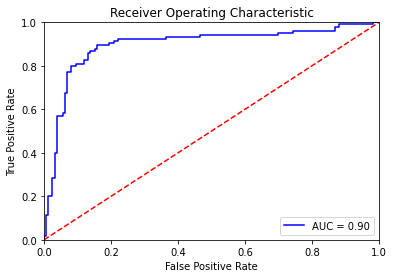

In [40]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC = %0.2f' % score_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("./Plots/roc_curve")
plt.show()

Interpretation

invalid value encountered in true_divide
invalid value encountered in true_divide


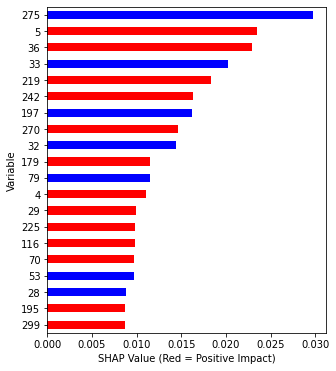

In [35]:

best_rf=grid.best_estimator_

# Shap values

DF_ehr_train_val=pd.DataFrame(ehrs_vec_train_val)
DF_ehr_train_val.columns=range(300)

shap_values = shap.TreeExplainer(best_rf).shap_values(DF_ehr_train_val)

shap_values=np.array(shap_values)[0]
explainer=shap.TreeExplainer(best_rf)

# !!! Bout de code copié sur https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
###

shap_v = pd.DataFrame(shap_values)
feature_list = DF_ehr_train_val.columns
shap_v.columns = feature_list
df_v = DF_ehr_train_val.copy().reset_index().drop('index',axis=1)

# Determine the correlation in order to plot with different colors
corr_list = list()
for i in feature_list:
    b = np.corrcoef(shap_v[i],df_v[i])[1][0]
    corr_list.append(b)
corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
# Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
corr_df.columns  = ['Variable','Corr']
corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')

# Plot it
shap_abs = np.abs(shap_v)
k=pd.DataFrame(shap_abs.mean()).reset_index()
k.columns = ['Variable','SHAP_abs']
k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
k2 = k2.sort_values(by='SHAP_abs',ascending = True)
k2=k2[-20:]
colorlist = k2['Sign']
ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
ax.set_xlabel("SHAP Value (Red = Positive Impact)")
plt.savefig("./Plots/SHAP_values") 
###